In [1]:
import os

os.getcwd()
os.chdir("../../")
os.getcwd()

'/data01/dl23vitcas/dl_project'

In [2]:
import sys
import argparse
import os

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

config/single_task_object_detection.yaml


In [3]:
from dataloader import VOC08Attr
from torchvision.transforms import transforms
from config_experiments import config
import torch
from torch.utils.data import DataLoader

import numpy as np

In [4]:
transform_train = transforms.Compose(
    [
        transforms.Resize(size=600, max_size=1000),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [5]:
train_data = VOC08Attr(train=True, transform=transform_train)
train_dataloader = DataLoader(
    train_data,
    batch_size=config["preprocessing"]["n_images"],
    collate_fn=train_data.collate_fn,
    shuffle=False,
)

In [37]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bbox_with_transform(image, box, mean, std, labels=None, color="white"):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    show(draw_bounding_boxes(image, box, colors=color, labels=labels, width=2))

tensor([[  0., 194., 678., 600.],
        [247.,  76., 454., 250.],
        [275.,  84., 412., 225.],
        [275.,  75., 462., 225.],
        [178.,  80., 678., 600.],
        [180.,  59., 678., 600.],
        [  0.,  80., 678., 600.],
        [  0.,  44., 678., 600.],
        [275.,  75., 418., 225.],
        [290.,  78., 454., 223.],
        [  0.,   0., 678., 600.],
        [136.,   0., 678., 600.],
        [176.,  75., 462., 248.],
        [  0.,   0., 678., 280.],
        [188., 220., 348., 600.],
        [378.,  93., 656., 154.],
        [312., 152., 488., 358.],
        [ 89., 206., 315., 585.],
        [304., 149., 507., 358.],
        [298., 345., 678., 600.],
        [  0., 320., 149., 600.],
        [304., 422., 670., 547.],
        [316., 239., 511., 373.],
        [  0., 168., 286., 297.],
        [336., 170., 419., 269.],
        [  0.,   0., 392., 141.],
        [372.,   0., 580., 154.],
        [290., 470., 678., 600.],
        [298., 345., 616., 581.],
        [354.,

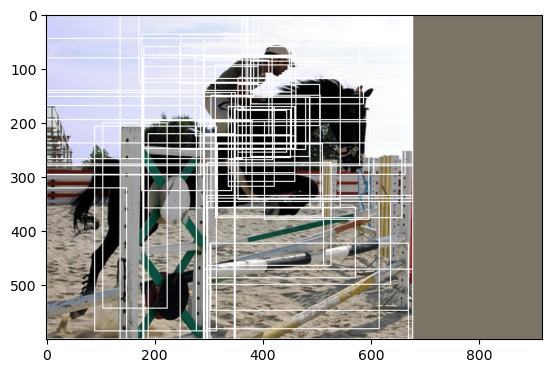

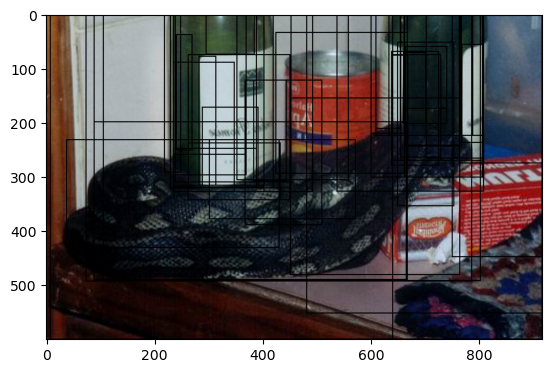

In [45]:
for i, (batch_images, rois, classes, offsets, attrs, indices_batch) in enumerate(
    train_dataloader
):
    # show(batch_images[0])
    # show(batch_images[1])
    # print(rois.shape)
    print(rois[indices_batch.squeeze(-1) == 0])
    show_bbox_with_transform(
        batch_images[0],
        rois[indices_batch.squeeze(-1) == 0],
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
        labels=None,
        color="white",
    )
    print(rois[indices_batch.squeeze(-1) == 1])
    show_bbox_with_transform(
        batch_images[1],
        rois[indices_batch.squeeze(-1) == 1],
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
        labels=None,
        color="black",
    )
    if i == 5:
        break

In [54]:
for i, (image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois) in enumerate(
    train_data
):
    print(img_size_orig)
    print(image.shape)

    break

(500, 442)
torch.Size([3, 600, 678])


In [30]:
from torchvision.transforms import transforms

img1 = torch.rand(3, 500, 376)
img1 = transforms.Resize(size=600, max_size=1000)(img1)
img1.shape

torch.Size([3, 797, 600])

In [6]:
def get_normalize_values_target_class(data_loader):
    offsets_by_class = {i: [] for i in range(1, config["global"]["num_classes"] + 1)}
    for i, (image, train_roi, train_cls, train_offset, _, indices_batch) in enumerate(
        data_loader
    ):
        for cls, offset in zip(train_cls, train_offset):
            if cls.item() in offsets_by_class and cls.item() != 0:
                offsets_by_class[cls.item()].append(offset)

    mean_std_by_class = {}
    for cls, offsets in offsets_by_class.items():
        offsets_tensor = torch.stack(offsets)
        mean = torch.mean(offsets_tensor, dim=0)
        std = torch.std(offsets_tensor, dim=0)
        mean_std_by_class[cls] = {
            "mean": mean.tolist(),
            "std": std.tolist(),
        }

    return mean_std_by_class

In [7]:
mean_std_by_class = get_normalize_values_target_class(train_dataloader)

In [8]:
import json

with open(
    os.getcwd()
    + "/src/single_task_object_detection/"
    + "target_mean_std_by_class.yaml",
    "w",
) as f:

    json.dump(mean_std_by_class, f)

In [9]:
import yaml

with open(
    os.getcwd()
    + "/src/single_task_object_detection/"
    + "target_mean_std_by_class.yaml",
    "r",
) as f:
    mean_std_by_class = yaml.safe_load(f)

    print(mean_std_by_class)

{'1': {'mean': [-0.004869887605309486, 0.02848670817911625, 0.010922333225607872, 0.06680185347795486], 'std': [0.1457379311323166, 0.11888788640499115, 0.26273253560066223, 0.20553985238075256]}, '2': {'mean': [0.0007696108659729362, -0.010962811298668385, -0.04365643113851547, 0.14113980531692505], 'std': [0.12641896307468414, 0.14986152946949005, 0.2552206814289093, 0.22922366857528687]}, '3': {'mean': [0.012703349813818932, -0.024916918948292732, -0.08840286731719971, 0.1699591726064682], 'std': [0.11636277288198471, 0.14713777601718903, 0.23492717742919922, 0.21578577160835266]}, '4': {'mean': [-0.0007146837888285518, 0.007131843362003565, 0.041338346898555756, 0.06805076450109482], 'std': [0.1278640180826187, 0.11678770184516907, 0.2446833699941635, 0.20741741359233856]}, '5': {'mean': [0.007103521842509508, 0.03286739066243172, 0.052475348114967346, 0.11584538221359253], 'std': [0.10255298018455505, 0.1287728101015091, 0.20558281242847443, 0.23587089776992798]}, '6': {'mean': [0